Stochastic Gradient descent
===========================

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$
$\newcommand{\eqdef}{\equiv}$

This tour details Stochastic Gradient Descent, applied to the binary logistic classification problem.

We recommend that after doing this Numerical Tours, you apply it to your
own data, for instance using a dataset from [LibSVM](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/).

_Disclaimer:_ these machine learning tours are intended to be
overly-simplistic implementations and applications of baseline machine learning methods.
For more advanced uses and implementations, we recommend
to use a state-of-the-art library, the most well known being
[Scikit-Learn](http://scikit-learn.org/)

In [1]:
library(plot3D)
library(pracma)

# Importing the libraries
for (f in list.files(path="nt_toolbox/toolbox_general/", pattern="*.R")) {
    source(paste("nt_toolbox/toolbox_general/", f, sep=""))
}
for (f in list.files(path="nt_toolbox/toolbox_signal/", pattern="*.R")) {
    source(paste("nt_toolbox/toolbox_signal/", f, sep=""))
}

Warning message:
"package 'plot3D' was built under R version 3.3.2"Warning message:
"package 'tuneR' was built under R version 3.3.2"Warning message:
"package 'akima' was built under R version 3.3.2"

Define a few helper functions:

In [2]:
fs = 10

Xm = function(X){as.matrix(X - rep(colMeans(X), rep.int(nrow(X), ncol(X))))}
Cov = function(X){data.matrix(1. / (n - 1) * t(Xm(X)) %*% Xm(X))}

Simple Example
--------------
We first illustrate the concept of stochastic gradient descent on a
simple example
$$ \umin{x \in \RR} f(x) \eqdef f_1(x) + f_2(x) $$
where $f_1(x) \eqdef (x-1)^2$ and
$f_2(x) \eqdef (x+1)^2$.


Functions and their derivatives.

In [3]:
f = function(x,i)
{
    if (i==1)
    {
        return(0.5 * (x - 1)**2)
    }
    else
    {
        return(0.5 * (x + 1)**2)
    }
}

df = function(x,i)
{
    if (i==1)
    {
        return(x - 1)
    }
    else
    {
        return(x + 1)
    }
}

F = function(x){f(x,1) + f(x,2)}

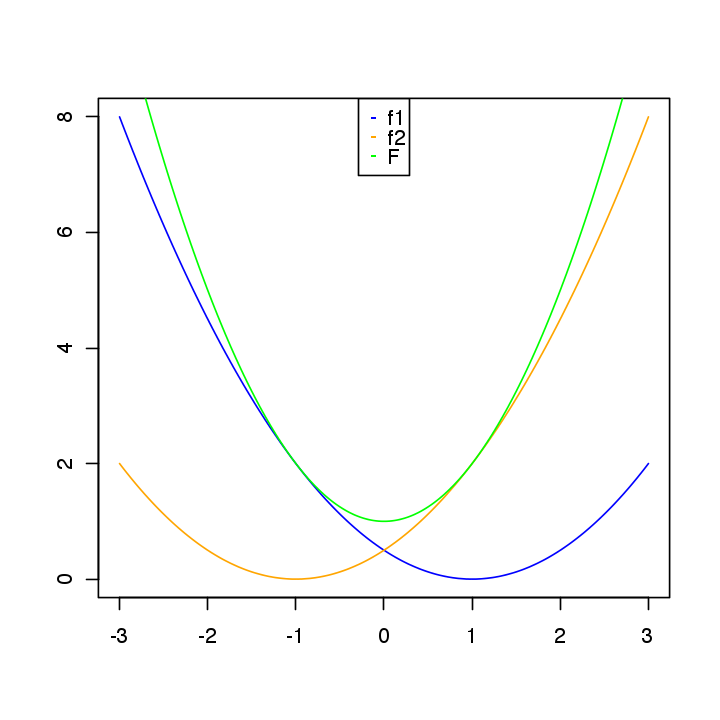

In [4]:
options(repr.plot.width=6, repr.plot.height=6)
t = seq(-3,3, length=201)
plot(t, f(t,1), col="blue", type='l', ylab="", xlab="")
lines(t, f(t,2), col="orange", type='l')
lines(t, F(t), col="green", type='l')
legend("top", legend=c("f1", "f2", "F"), col=c("blue", "orange", "green"), pch="-")

Each iteration of SGD reads
$$ x_{\ell+1} = x_\ell - \tau_\ell \nabla f_{i(\ell)}(x_\ell) $$
where $ i(\ell) \in \{1,2\} $ is drawn uniformly.

__Exercise 0__

Implement the SGD, with a random initial condition $x_0$.
Display several paths (i.e. run several times the algorithm)
to vizualize the evolution of the density of the random variable
$x_\ell$.

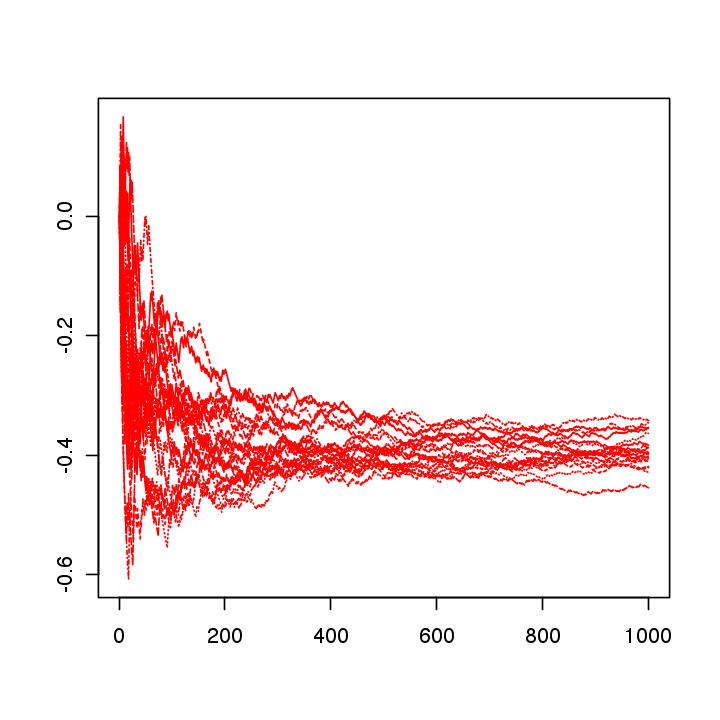

In [5]:
q = 20  # Number of paths computed in parallel.
niter = 1000

x = matrix(0, q, niter)
x[,0] = randn(q,1) - .5 # Initial conditions.

for (i in 2:niter)
{
    u = randn(q,1) > 0.5
    xx = x[, i - 1]
    tau = 1.0 / (10 + i)
    x1 = xx - tau * (u * df(xx,1) + (1-u) * df(xx,2))
    x[,i] = x1
}


matplot(t(x), col='red', type="l", xlab="", ylab="")

In [6]:
## Insert your code here.

Dataset Loading
---------------
We load a subset of the <http://osmot.cs.cornell.edu/kddcup/datasets.html
dataset Quantum Physics Dataset>
of $n=10000$ features in dimension $78$. The goal in this task is to learn a classification rule that differentiates between two types of particles generated in high energy collider experiments.



Load the dataset.
Randomly permute it.
Separate the features $X$ from the data $y$ to predict information.

In [7]:
file_name = 'nt_toolbox/data/quantum.csv'
A = read.table(file_name, sep=",", head=FALSE)
A = A[sample(dim(A)[1]),]
X = A[,1:(dim(A)[2] - 1)]
y = A[,dim(A)[2]]

Set the classes indexes to be $\{-1,+1\}$.

In [8]:
y = (2 * y - 1)

Remove empty features, normalize $X$.

In [9]:
I = colMeans(abs(X)) > 1e-1 
X = X[,I]
X = scale(X)

ERROR: Error in Math.data.frame(X): non-numeric variable in data frame: V1


$n$ is the number of samples, $p$ is the dimensionality of the features,

In [ ]:
n = dim(X)[1]
p = dim(X)[2]

Compute PCA main axes for display.

In [ ]:
svd_decomp = svd(Xm(X))
U = svd_decomp$u
s = svd_decomp$d
V = svd_decomp$v
Xr = X %*% t(V)

options(repr.plot.width=4, repr.plot.height=4)
plot(s, type="o", col=4, ylab="", xlab="", pch=16)

Plot the classes.

In [ ]:
options(repr.plot.width=5, repr.plot.height=5)
I = sample(n)
I = I[1:200]
plot_multiclasses(X[I,],y[I], 2)

In [ ]:
plot_multiclasses(X[I,],y[I], 3)

Batch Gradient Descent (BGD)
----------------------------
We first test the usual (batch) gradient descent (BGD) on the problem of
supervised logistic classification.


We refer to the dedicated numerical tour on logistic classification for
background and more details about the derivations of the energy and its
gradient.


Logistic classification aims at solving the following convex program
  $$ \umin{w} E(w) \eqdef \frac{1}{n} \sum_{i=1}^n L(\dotp{x_i}{w},y_i)  $$
where the logistic loss reads
  $$ L( s,y ) \eqdef \log( 1+\exp(-sy) ) $$


Define energy $E$ and its gradient $\nabla E$.

In [ ]:
L = function(s,y){1/n * sum( log(1 + exp(-s * y)))}
E = function(w,X,y){L(X %*% w, y)}
theta = function(v){1 / (1 + exp(-v))}
nablaL = function(s, r){ - 1/n * y * theta(-s * y)}
nablaE = function(w,X,y){t(X) %*% nablaL(X %*% w,y)}

__Exercise 1__

Implement a gradient descent
$$ w_{\ell+1} = w_\ell - \tau_\ell \nabla E(w_\ell). $$
Monitor the energy decay.
Test different step size, and compare with the theory (in particular
plot in log domain to illustrate the linear rate).

In [ ]:
## Insert your code here.

Stochastic Gradient Descent (SGD)
---------------------------------
As any empirical risk minimization procedure, the
logistic classification minimization problem can be written as
$$ \umin{w} E(w) = \frac{1}{n} \sum_i E_i(w) \qwhereq E_i(w) = L(\dotp{x_i}{w},y_i). $$


For very large $n$ (which could in theory even be infinite, in which case the sum needs to be replaced
by an expectation or equivalenty an integral), computing $\nabla E$ is prohebitive.
It is possible instead to use a stochastic gradient descent (SGD) scheme
  $$ w_{\ell+1} = w_\ell - \tau_\ell \nabla E_{i(\ell)}(w_\ell) $$
where, for each iteration index $\ell$, $i(\ell)$
is drawn uniformly at random in $  \{1,\ldots,n\} $.


Note that here
$$ \nabla E_{i}(w) = x_i \nabla L( \dotp{x_i}{w}, y_i )
  \qwhereq  \nabla L(u,v) = v \odot \th(-u)  $$

In [ ]:
nablaEi = function(w,i){as.numeric(-y[i] * t(X[i,]) * c(theta(-y[i] * (X[i,] %*% w))))}

Note that each step of a batch gradient descent has complexity $O(np)$,
while a step of SGD only has complexity $O(p)$. SGD is thus
advantageous when $n$ is very large, and one cannot afford to do
several passes through the data. In some situation, SGD can provide
accurate results even with $\ell \ll n$, exploiting redundancy between
the samples.


A crucial question is the choice of step size schedule $\tau_\ell$. It
must tends to 0 in order to cancel the noise induced on the gradient by
the stochastic sampling. But it should not go too fast to zero in order
for the method to keep converging.


A typical schedule that ensures both properties is to have asymptically $\tau_\ell \sim \ell^{-1}$ for
$\ell\rightarrow +\infty$. We thus propose to use
$$ \tau_\ell \eqdef \frac{\tau_0}{1 + \ell/\ell_0} $$
where $\ell_0$ indicates roughly the number of iterations serving as a
"warmup" phase.


One can prove the following convergence result
 $$ \EE( E(w_\ell) ) - E(w^\star) = O\pa{ \frac{1}{\sqrt{\ell}} }, $$
where $\EE$ indicates an expectation with respect to the i.i.d.
sampling performed at each iteration.


Select default values for $ (\ell_0,\tau_0) $.

In [ ]:
l0 = 100
tau0 = 0.05

__Exercise 2__

Perform the Stochastic gradient descent.
Display the evolution of the energy $E(w_\ell)$.
One can overlay on top (black dashed curve) the convergence of the batch gradient descent, with a carefull scaling of the
number of iteration to account for the fact that the complexity of a batch iteration is $n$ times larger.
Perform several runs to illustrate the probabilistic nature of the method.
Explore different values for $ (\ell_0,\tau_0) $.

In [ ]:
## Insert your code here.

Stochastic Gradient Descent with Averaging (SGA)
------------------------------------------------
Stochastic gradient descent is slow because of the fast decay of
$\tau_\ell$ toward zero.


To improve somehow the convergence speed, it is possible to average the past
iterate, i.e. run a "classical" SGD on auxiliary variables $ (\tilde w_\ell)_\ell$
  $$ \tilde w_{\ell+1} = \tilde w_\ell - \tau_\ell \nabla E_{i(\ell)}(\tilde w_\ell) $$
and output as estimated weight vector the average
$$ w_\ell \eqdef \frac{1}{\ell} \sum_{k=1}^\ell \tilde w_\ell. $$
This defines the Stochastic Gradient Descent with Averaging (SGA)
algorithm.


Note that it is possible to avoid explicitely storing all the iterates by simply
updating a running average as follow
$$ w_{\ell+1} = \frac{1}{\ell} \tilde w_\ell +  \frac{\ell-1}{\ell} w_\ell.  $$


In this case, a typical choice of decay is rather of the form
$$ \tau_\ell \eqdef \frac{\tau_0}{1 + \sqrt{\ell/\ell_0}}. $$
Notice that the step size now goes much slower to 0, at rate $\ell^{-1/2}$.


Typically, because the averaging stabilizes the iterates, the choice of
$(\ell_0,\tau_0)$ is less important than for SGD.


[Bach proves that](https://arxiv.org/pdf/1303.6149.pdf) for logistic classification,
it leads to a faster convergence (the constant involved are
smaller) than SGD, since
on contrast to SGD, SGA is adaptive to the local strong convexity of $E$.

__Exercise 3__

Implement the Stochastic gradient descent with averaging.
Display the evolution of the energy $E(w_\ell)$.

In [ ]:
## Insert your code here.

Stochastic Averaged Gradient Descent (SAG)
------------------------------------------
For problem size $n$ where the dataset (of size $n \times p$) can
fully fit into memory, it is possible to further improve the SGA method
by bookeeping the previous gradient. This gives rise to the
[Stochastic Averaged Gradient Descent (SAG)](https://arxiv.org/pdf/1309.2388) algorithm.


We stored all the previously computed gradient in $ (G^i)_{i=1}^n $,
which necessitate $n \times p$ memory.
The iterates are defined by using a proxy $g$ for the batch gradient,
which is progressively enhanced during the iterates.


The algorithm reads
$$ h \leftarrow \nabla E_{i(\ell)}(\tilde w_\ell), $$
$$ g  \leftarrow g - G^{i(\ell)} + h,   $$
$$ G^{i(\ell)} \leftarrow h,  $$
$$ w_{\ell+1} = w_\ell - \tau g.  $$
Note that in contrast to SGD and SGA, this method uses a fixed step
size $\tau$. Similarely to the BGD, in order to ensure convergence,
the step size $\tau$ should be of the order of $1/L$
where $L$ is the Lipschitz constant of $E$.


This algorithm improves over SGA and BGD
since it has a convergence rate of $O(1/\ell)$.
Furthermore, in the presence of strong convexity (for instance when $X$ is
injective for logistic classification), it has a linear convergence rate,
i.e.
 $$ \EE( E(w_\ell) ) - E(w^\star) = O\pa{ \rho^\ell }, $$
for some $0 < \rho < 1$.


Note that this improvement over SGD and SGA is made possible only because
SAG explictely use the fact that $n$ is finite (while SGD and SGA can
be extended to infinite $n$ and more general minimization of
expectations).

__Exercise 4__

Implement SAG.
Display the evolution of the energy $E(w_\ell)$.

In [ ]:
## Insert your code here.